## Grokking Hacking 6

In [1]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import transformer_lens
except:
    %pip install transformer_lens==2.11.0

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/{repo}-{branch}

if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

In [2]:
import os
import sys
from functools import partial
from pathlib import Path

import einops
import numpy as np
import torch as t
import torch.nn.functional as F
from huggingface_hub import hf_hub_download
from jaxtyping import Float
from torch import Tensor
from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import to_numpy
import matplotlib.pyplot as plt
from ipywidgets import interact

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
section = "part52_grokking_and_modular_arithmetic"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section

grokking_root = section_dir / "Grokking"
saved_runs_root = grokking_root / "saved_runs"

import part52_grokking_and_modular_arithmetic.tests as tests
import part52_grokking_and_modular_arithmetic.utils as utils

device = t.device("cuda" if t.cuda.is_available() else "cpu")

t.set_grad_enabled(False)

MAIN = __name__ == "__main__"

In [3]:
p = 113

cfg = HookedTransformerConfig(
    n_layers=1,
    d_vocab=p + 1,
    d_model=128,
    d_mlp=4 * 128,
    n_heads=4,
    d_head=128 // 4,
    n_ctx=3,
    act_fn="relu",
    normalization_type=None,
    device=device,
)

model = HookedTransformer(cfg)

In [4]:
REPO_ID = "callummcdougall/grokking_full_run_data"
FILENAME = "full_run_data.pth"

local_dir = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

full_run_data = t.load(local_dir, weights_only=True)
state_dict = full_run_data["state_dicts"][400]

model = utils.load_in_state_dict(model, state_dict)

In [5]:
# Get all data and labels, and cache activations
all_data = t.tensor([(i, j, p) for i in range(p) for j in range(p)]).to(device)
labels = t.tensor([utils.target_fn(i, j) for i, j, _ in all_data]).to(device)
original_logits, cache = model.run_with_cache(all_data)

# Final position only, also remove the logits for `=`
original_logits = original_logits[:, -1, :-1]

# Get cross entropy loss
original_loss = utils.cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item():.3e}")

Original loss: 2.412e-07


- Ok model is loaded up -> what's going to give me the best chance here of finding the patterns I'm looking for?
- I'm' mean yeah various activations and certainly functional form for weights is nice -> althougth it's not that accurate, but I think that's ok right now. 

In [6]:
# Helper variables
W_O = model.W_O[0]
W_K = model.W_K[0]
W_Q = model.W_Q[0]
W_V = model.W_V[0]
W_in = model.W_in[0]
W_out = model.W_out[0]
W_pos = model.W_pos
W_E = model.W_E[:-1]
final_pos_resid_initial = model.W_E[-1] + W_pos[2]
W_U = model.W_U[:, :-1]

#Functional Form
W_logit = W_out @ W_U

W_OV = W_V @ W_O
W_neur = W_E @ W_OV @ W_in

W_QK = W_Q @ W_K.transpose(-1, -2)
W_attn = final_pos_resid_initial @ W_QK @ W_E.T / (cfg.d_head**0.5)

Ok, let's start with hunting for clean sines and cosines of the inputs. 

In [7]:
for k in cache:
    print(k, cache[k].shape)

hook_embed torch.Size([12769, 3, 128])
hook_pos_embed torch.Size([12769, 3, 128])
blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_q torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


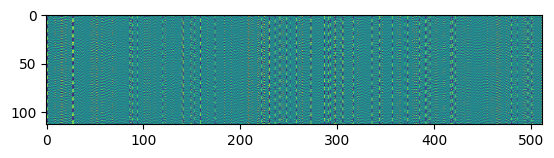

In [8]:
plt.imshow((W_neur[1]).detach().cpu().numpy())

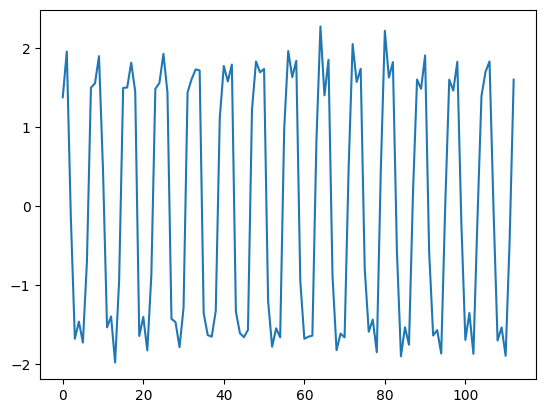

In [9]:
plt.plot((W_neur[1][:,1]).detach().cpu().numpy())

In [10]:
def fourier_approx_1d(x, num_freqs):
    """
    x: 1D real array, length N
    num_freqs: number of *unique* frequency modes to keep (by magnitude),
               counting k>0 and N-k as one mode.

    Returns:
        F_sparse: sparse 1D Fourier spectrum (complex, same shape as x)
        x_hat: real reconstruction from the sparse spectrum
    """
    N = len(x)
    F = np.fft.fft(x)

    # Unique freqs for real signals: 0..N//2 (if even) or 0..(N-1)//2 (if odd)
    if N % 2 == 0:
        max_k = N // 2
    else:
        max_k = (N - 1) // 2

    ks = np.arange(0, max_k + 1)
    mags = np.abs(F[ks])

    # Sort unique ks by magnitude (descending)
    idx_sorted = np.argsort(mags)[::-1]
    keep_ks = ks[idx_sorted[:num_freqs]]

    # Build sparse spectrum, preserving conjugate pairs
    F_sparse = np.zeros_like(F, dtype=complex)
    for k in keep_ks:
        F_sparse[k] = F[k]
        # DC and Nyquist have no distinct conjugate partner
        if k != 0 and not (N % 2 == 0 and k == N // 2):
            F_sparse[-k] = F[-k]

    x_hat = np.fft.ifft(F_sparse).real
    return F_sparse, x_hat


def spectrum_to_terms_1d(F_sparse):
    N = len(F_sparse)

    if N % 2 == 0:
        max_k = N // 2
    else:
        max_k = (N - 1) // 2

    terms = []

    for k in range(0, max_k + 1):
        c = F_sparse[k]
        if c == 0:
            continue

        if k == 0 or (N % 2 == 0 and k == N // 2):
            amp = np.abs(c) / N
        else:
            amp = 2 * np.abs(c) / N

        phase = np.angle(c)

        terms.append({
            "k": k,
            "amplitude": amp,
            "phase": phase
        })

    return terms


def generate_python_reconstructor_1d(terms, N, func_name="recon_func_1d", decimals=4):
    lines = []
    lines.append(f"def {func_name}(i):")

    if len(terms) == 0:
        lines.append("    return 0.0")
        return "\n".join(lines)

    lines.append("    return (")

    for t in terms:
        k = t["k"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        line = f"        {A} * np.cos(2*np.pi*(({k}*i)/{N}) + {phi}) +"
        lines.append(line)

    lines[-1] = lines[-1].rstrip(" +")
    lines.append("    )")

    return "\n".join(lines)


In [11]:
neuron_idx=2
sig=W_neur[1][:,neuron_idx].detach().cpu().numpy()

F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
terms_1d = spectrum_to_terms_1d(F_sparse)
code_1d = generate_python_reconstructor_1d(terms_1d, N=p)

In [12]:
terms_1d, 

([{'k': 42, 'amplitude': 1.4386335565988873, 'phase': -2.075477679773325}],)

In [13]:
np.linalg.norm(sig-x_hat)/np.linalg.norm(sig)

0.09087369331058082

In [14]:
print(code_1d)

def recon_func_1d(i):
    return (
        1.4386 * np.cos(2*np.pi*((42*i)/113) + -2.0755)
    )


In [15]:
def recon_func_1d(i):
    return (
        2.06 * np.cos(2*np.pi*((14*i)/113) + -0.1388)
    )

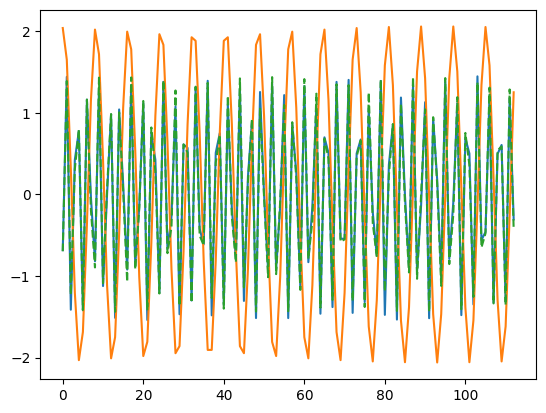

In [16]:
plt.plot((W_neur[1][:,neuron_idx]).detach().cpu().numpy())
plt.plot(recon_func_1d(np.arange(p)))
plt.plot(x_hat, '--')

In [17]:
head_index=1
res=[]
for neuron_idx in range(512):
    sig=W_neur[head_index][:,neuron_idx].detach().cpu().numpy()
    
    F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
    terms_1d = spectrum_to_terms_1d(F_sparse)
    # code_1d = generate_python_reconstructor_1d(terms_1d, N=p)

    # print(terms_1d, np.linalg.norm(sig-x_hat)/np.linalg.norm(sig))
    # if terms_1d[0]['k']==14:
    terms_1d[0]['neuron_idx']=neuron_idx
    terms_1d[0]['err']=np.linalg.norm(sig-x_hat)/np.linalg.norm(sig)
    res.append(terms_1d[0])

In [18]:
import pandas as pd

In [19]:
df=pd.DataFrame(res)

In [20]:
df_k14 = df[df["k"] == 14]
closest_rows = df_k14.iloc[(df_k14["phase"].abs()).argsort()]
closest_rows.head()

k  amplitude     phase  neuron_idx       err
230  14   2.415505 -0.047226         230  0.316667
1    14   2.059959 -0.138764           1  0.296022
306  14   2.374447 -0.233859         306  0.290888
419  14   1.901981  0.273444         419  0.274719
298  14   2.175374  0.288929         298  0.267828

In [21]:
closest_rows = df_k14.iloc[(np.abs(df_k14["phase"] - np.pi/2)).argsort()]
closest_rows.head()

k  amplitude     phase  neuron_idx       err
336  14   2.068552  1.613765         336  0.293917
273  14   2.259683  1.753504         273  0.338657
27   14   2.212050  1.852999          27  0.308731
392  14   1.475397  1.209497         392  0.238566
159  14   2.092513  1.941471         159  0.305798

In [22]:
closest_rows = df_k14.iloc[(np.abs(df_k14["phase"] + np.pi/2)).argsort()]
closest_rows.head()

k  amplitude     phase  neuron_idx       err
396  14   1.624393 -1.447018         396  0.255781
153  14   1.383132 -1.446893         153  0.255855
370  14   1.217414 -1.446760         370  0.256032
293  14   1.775200 -1.802208         293  0.231595
486  14   1.265198 -1.846968         486  0.230346

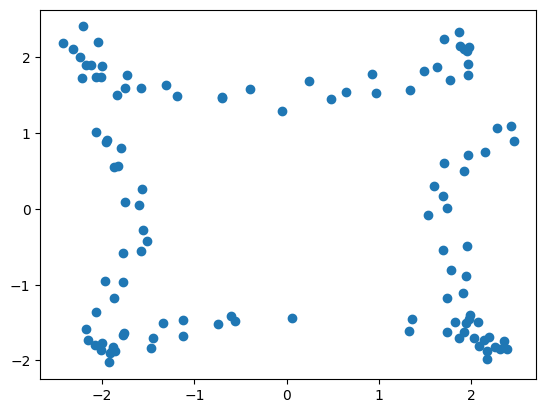

In [23]:
plt.scatter(W_neur[1][:,230].detach().cpu().numpy(), W_neur[1][:,336].detach().cpu().numpy())

In [24]:
m=W_neur[1].detach().cpu().numpy()

In [25]:
m.shape

(113, 512)

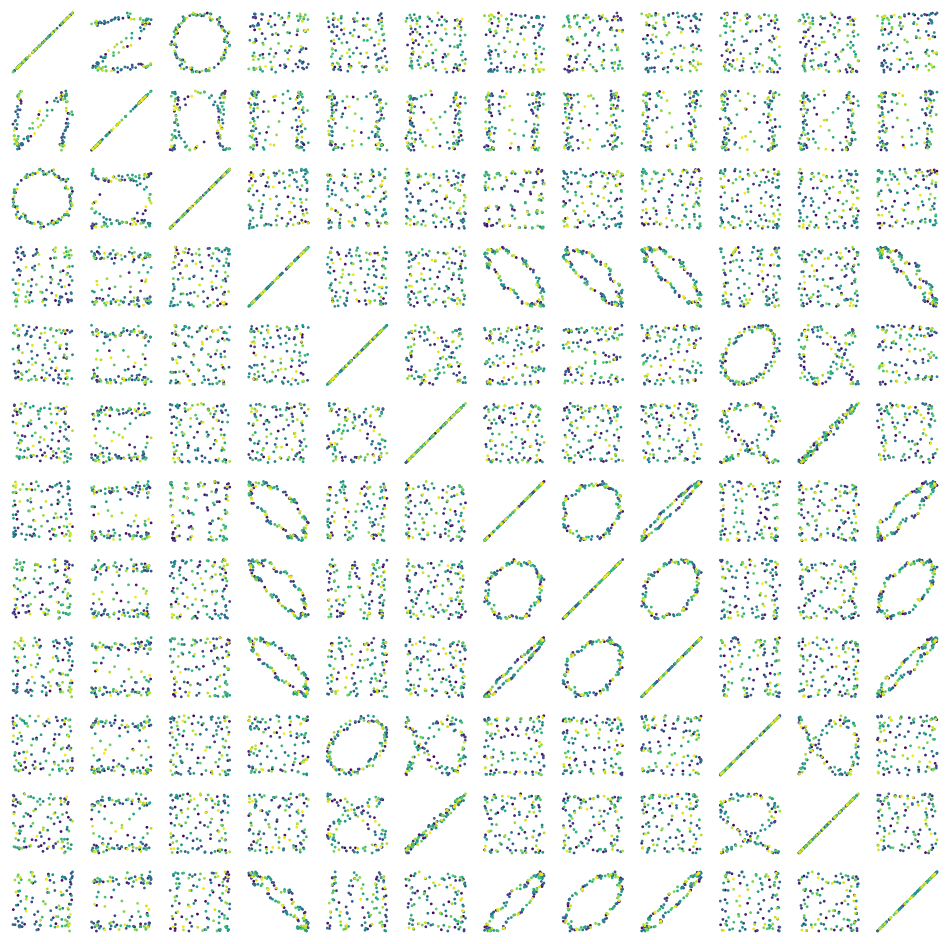

In [26]:
fig=plt.figure(0, (12,12))
for i in range(12):
    for j in range(12):
        fig.add_subplot(12,12,12*i+j+1)
        plt.scatter(m[:,i], m[:, j], c=range(113), s=1)
        plt.axis('off')

In [27]:
neuron_idx=2
sig=W_neur[1][:,neuron_idx].detach().cpu().numpy()

F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
terms_1d = spectrum_to_terms_1d(F_sparse)
code_1d = generate_python_reconstructor_1d(terms_1d, N=p)

In [28]:
print(code_1d)

def recon_func_1d(i):
    return (
        1.4386 * np.cos(2*np.pi*((42*i)/113) + -2.0755)
    )


In [29]:
neuron_idx=0
sig=W_neur[1][:,neuron_idx].detach().cpu().numpy()

F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
terms_1d = spectrum_to_terms_1d(F_sparse)
code_1d = generate_python_reconstructor_1d(terms_1d, N=p)

In [30]:
print(code_1d)

def recon_func_1d(i):
    return (
        1.4858 * np.cos(2*np.pi*((42*i)/113) + 2.6837)
    )


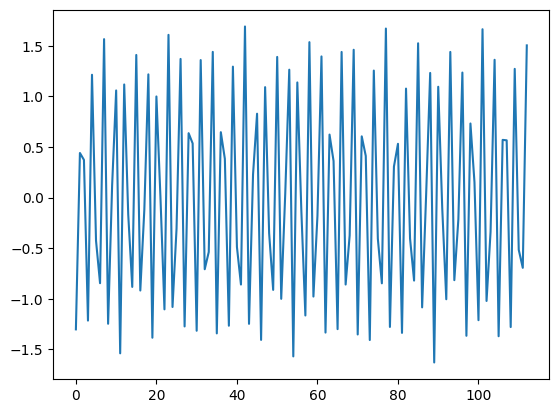

In [31]:
plt.plot((W_neur[1][:,0]).detach().cpu().numpy())
# plt.plot((W_neur[1][:,2]).detach().cpu().numpy())
# plt.plot(recon_func_1d(np.arange(p)))
# plt.plot(x_hat, '--')

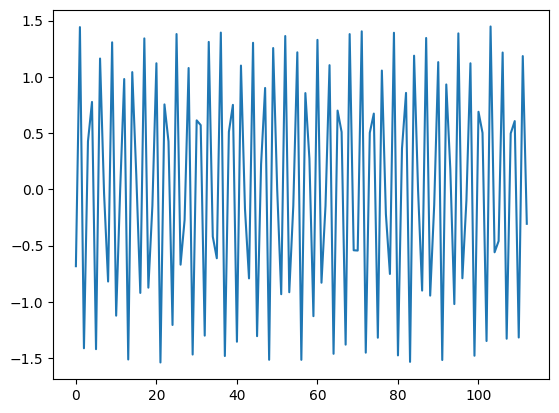

In [32]:
plt.plot((W_neur[1][:,2]).detach().cpu().numpy())

- Ok so that's a bit surprising, but still workable!
- Ok now what about the next set of terms here?
- So there's the products and then the sum of products making sum -> how/where can/should we pick off/visualize this stuff? 

In [33]:
m = all_data[:, 0]          # (N,)
n = all_data[:, 1]          # (N,)

t0 = F.one_hot(m, num_classes=p).float()   # (N, p)
t1 = F.one_hot(n, num_classes=p).float()   # (N, p)

# ----- 2. Compute alpha per head: α^h = σ(W_attn^h (t0 - t1)) -----
# diff: (N, p)
diff = t0 - t1

# W_attn: (n_heads, p)
# diff @ W_attn.T → (N, n_heads)
alpha = t.sigmoid(diff @ W_attn.T)         # (N, n_heads)

# For broadcasting later: (N, n_heads, 1)
alpha = alpha.unsqueeze(-1)

# ----- 3. Mix tokens per head: α^h t0 + (1-α^h) t1 -----
# Expand t0, t1 to (N, 1, p) to broadcast across heads
t0_exp = t0.unsqueeze(1)                   # (N, 1, p)
t1_exp = t1.unsqueeze(1)                   # (N, 1, p)

# token_mix: (N, n_heads, p)
token_mix = alpha * t0_exp + (1.0 - alpha) * t1_exp

# ----- 4. Map token_mix through W_neur -----
# W_neur: (n_heads, p, d_mlp)
# We want: (N, n_heads, d_mlp)
#
# Using einsum:
#  'nhp, hpd -> nhd'
neur_acts = t.einsum("nhp,hpd->nhd", token_mix, W_neur)  # (N, n_heads, d_mlp)

# Sum over heads: (N, d_mlp)
pre_mlp = neur_acts.sum(dim=1)

# ----- 5. ReLU, then logit projection -----
hidden = F.relu(pre_mlp)                  # (N, d_mlp)
logits = hidden @ W_logit                # (N, p)

Ok so I think the potential locations for picking off/visualizing these terms are: 

1. blocks.0.mlp.hook_pre 
2. blocks.0.mlp.hook_post
3. neur_acts
4. pre_mlp

- So yeah let's focus on the individual cross terms first, then on the sum/addition part. 
- Assuming these could happen at different or same frequencies -> same frequency would be easier to make sense of.
- Hmm so I kinda feel like a 2d grid is a good starting point here? Not sure if there's a good scatter plot for these terms?
- Let me start with the 2d grid.
- I gueess a surface in 3d could be interesting/maybe helpful to see in manim! Especially we work with projections or something. 

In [87]:
m=cache['blocks.0.mlp.hook_pre'].detach().cpu().numpy()
mr = einops.rearrange(cache['blocks.0.mlp.hook_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

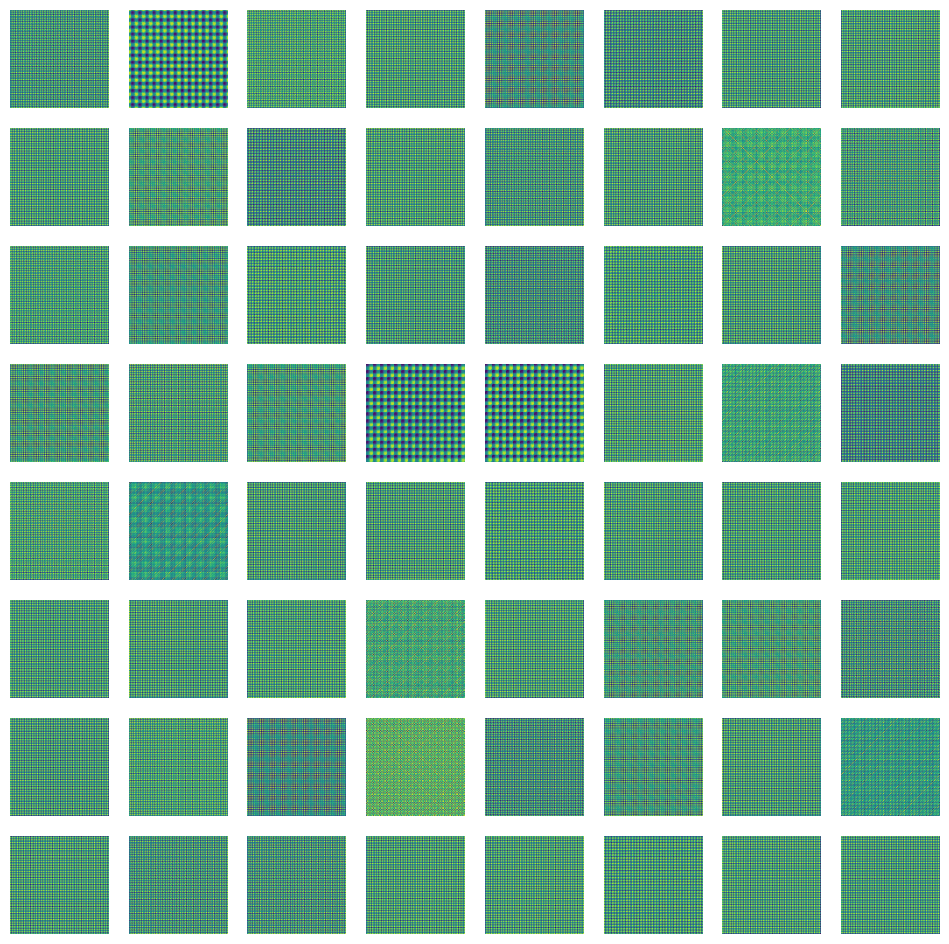

In [88]:
fig=plt.figure(0, (12,12))
for i in range(64):
    fig.add_subplot(8,8, i+1)
    plt.imshow(mr[:,:,2,i])
    plt.axis('off')

- Ok what would a product of two things look like and how do I find it? 
- how do these compare to "addition" terms -> is it easy to tell these apart? Maybe looking across various locations will helps?
- Ok so thinking a little more -> I think there's really like 3 different types of patterns we can look for here across 4+ locations:
- Weighted sum of trig(wx), trig(wy)
- Product of trig(wx), trig(wy)
- some form of trig(w(x+y))

Hmm how I can I organize and automate my search. If some type of decomposition is required, I think I can make this since/intuitive by stacking surfaces in manim or something. But yeah let's see if that's reqruied or not. 

I have a big set of 113x113 matrices. I'm trying to decompose each matrix into trigonometric terms in a few different ways. Assuming that rows are indexed by x and columns are indexed by y, and we know that the k values (e.g. A*cos(2*np.pi*((k*x)/113)-phase)) will only be 14, 35, 41, 42, or 51. I want to test each matrix for how well: 

1. How well a weight sum matches: e.g. Acos(kx+phase)+Bcos(ky+phase)
2. How well a product matches: e.g. Acos(kx+phase)cos(ky+phase)
3. How well a "sum of angles" matches: e.g. A(cos(k(x+y)).

It's also possible that a matrix will containg a blend of 1-3. Before implementing a solution, let's discuss how we can test for various fits. 

In [89]:
def fourier_approx_2d(x, num_freqs):
    """
    x: 2D real array, shape (Nx, Ny)
    num_freqs: number of Fourier coefficients to keep (by magnitude)

    Returns:
        F_sparse: sparse 2D Fourier spectrum (complex, same shape as x)
        x_hat: real reconstruction from the sparse spectrum
    """
    # 2D FFT
    F = np.fft.fft2(x)
    
    # Flatten and sort coefficients by magnitude (descending)
    flat = F.ravel()
    idx_sorted = np.argsort(np.abs(flat))[::-1]
    
    # Indices of top num_freqs coefficients
    keep_idx = idx_sorted[:num_freqs]
    
    # Build sparse spectrum
    flat_sparse = np.zeros_like(flat, dtype=complex)
    flat_sparse[keep_idx] = flat[keep_idx]
    F_sparse = flat_sparse.reshape(F.shape)
    
    # Reconstruct (take real part to remove tiny numerical imaginary noise)
    x_hat = np.fft.ifft2(F_sparse).real
    
    return F_sparse, x_hat

def spectrum_to_terms(F_sparse):
    """
    Turn a sparse spectrum into a list of (kx, ky, amplitude, phase) terms.
    Only nonzero entries are returned.
    """
    Nx, Ny = F_sparse.shape
    terms = []
    
    for (kx, ky), c in np.ndenumerate(F_sparse):
        if c == 0:
            continue
        amp = np.abs(c) / (Nx * Ny)   # matches np.fft normalization
        phase = np.angle(c)
        terms.append({
            "kx": kx,
            "ky": ky,
            "amplitude": amp,
            "phase": phase
        })
    
    return terms

def generate_python_reconstructor(terms, Nx, Ny, func_name="recon_func", decimals=4):
    """
    Generate a Python function as a string that reconstructs the signal
    using explicit cosine terms from a sparse Fourier representation.
    """

    lines = []
    # lines.append("import numpy as np\n")
    lines.append(f"def {func_name}(i, j):")
    
    if len(terms) == 0:
        lines.append("    return 0.0")
        return "\n".join(lines)

    lines.append("    return (")

    for t in terms:
        kx, ky = t["kx"], t["ky"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        # One cosine term
        line = (
            f"        {A} * np.cos(2*np.pi*((({kx}*i)/{Nx}) + "
            f"(({ky}*j)/{Ny})) + {phi}) +"
        )
        lines.append(line)

    # Remove trailing '+'
    lines[-1] = lines[-1].rstrip(" +")

    lines.append("    )")

    return "\n".join(lines)

# def reconstruction_error(x, x_hat, remove_mean=True):
#     if remove_mean:
#         x=x-x.mean(); x_hat=x_hat-x_hat.mean()
#     diff = x - x_hat
#     mse = np.mean(diff**2)
#     rel_l2 = np.linalg.norm(diff) / np.linalg.norm(x)
#     return mse, rel_l2

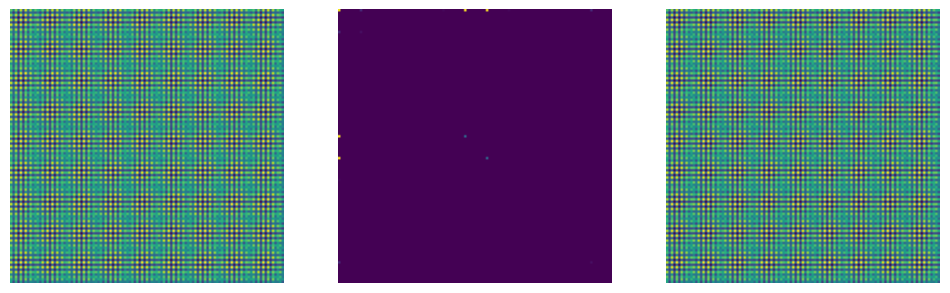

In [90]:
neuron_idx=4
F_sparse, x_hat = fourier_approx_2d(mr[:,:,2,neuron_idx], num_freqs =16)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(F_sparse));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(x_hat); plt.axis('off');

In [91]:
terms=spectrum_to_terms(F_sparse)
c=generate_python_reconstructor(terms, 113, 113)
print(c)

def recon_func(i, j):
    return (
        0.8729 * np.cos(2*np.pi*(((0*i)/113) + ((0*j)/113)) + -0.0) +
        0.1117 * np.cos(2*np.pi*(((0*i)/113) + ((9*j)/113)) + 1.2688) +
        0.0194 * np.cos(2*np.pi*(((0*i)/113) + ((43*j)/113)) + 1.342) +
        0.8868 * np.cos(2*np.pi*(((0*i)/113) + ((52*j)/113)) + 0.9769) +
        0.8868 * np.cos(2*np.pi*(((0*i)/113) + ((61*j)/113)) + -0.9769) +
        0.0194 * np.cos(2*np.pi*(((0*i)/113) + ((70*j)/113)) + -1.342) +
        0.1117 * np.cos(2*np.pi*(((0*i)/113) + ((104*j)/113)) + -1.2688) +
        0.1117 * np.cos(2*np.pi*(((9*i)/113) + ((0*j)/113)) + 1.269) +
        0.0381 * np.cos(2*np.pi*(((9*i)/113) + ((9*j)/113)) + -2.0923) +
        0.8879 * np.cos(2*np.pi*(((52*i)/113) + ((0*j)/113)) + 0.9765) +
        0.3025 * np.cos(2*np.pi*(((52*i)/113) + ((52*j)/113)) + 1.8906) +
        0.8879 * np.cos(2*np.pi*(((61*i)/113) + ((0*j)/113)) + -0.9765) +
        0.3025 * np.cos(2*np.pi*(((61*i)/113) + ((61*j)/113)) + -1.8906) +
        0.0194 *

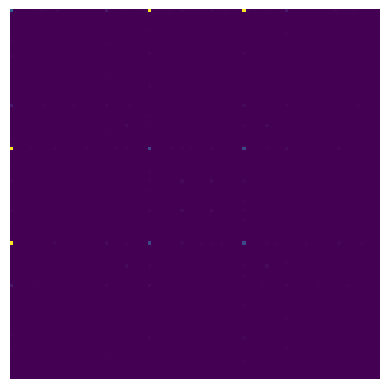

In [76]:
m=cache['blocks.0.mlp.hook_pre'].detach().cpu().numpy()
mr = einops.rearrange(cache['blocks.0.mlp.hook_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

# fig=plt.figure(0, (12,12))
for i in range(512):
    # fig.add_subplot(8,8, i+1)
    plt.clf()
    F_sparse, x_hat = fourier_approx_2d(mr[:,:,2,i], num_freqs=128)
    plt.imshow(np.abs(F_sparse));
    plt.axis('off')
    plt.savefig('/home/stephen/ARENA_3.0/viz/nov_24_1_pre/'+str(i).zfill(3)+'.png')

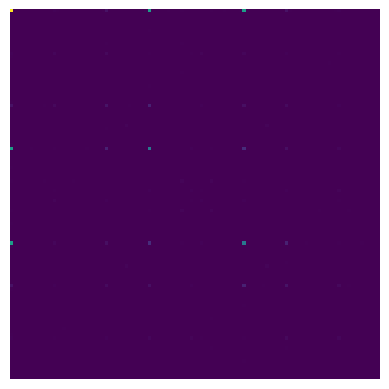

In [77]:
# m=cache['blocks.0.mlp.hook_pre'].detach().cpu().numpy()
mr = einops.rearrange(cache['blocks.0.mlp.hook_post'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

for i in range(512):
    plt.clf()
    F_sparse, x_hat = fourier_approx_2d(mr[:,:,2,i], num_freqs=128)
    plt.imshow(np.abs(F_sparse));
    plt.axis('off')
    plt.savefig('/home/stephen/ARENA_3.0/viz/nov_24_2_post/'+str(i).zfill(3)+'.png')

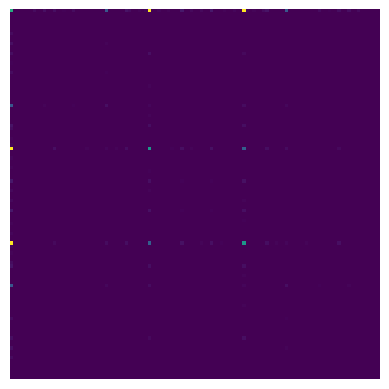

In [78]:
# neur_acts.shape
# head_id=0

for head_id in range(4):
    neur_acts_r = einops.rearrange(neur_acts[:,head_id,:], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()
    for i in range(512):
        plt.clf()
        F_sparse, x_hat = fourier_approx_2d(neur_acts_r[:,:,i], num_freqs=128)
        plt.imshow(np.abs(F_sparse));
        plt.axis('off')
        plt.savefig('/home/stephen/ARENA_3.0/viz/nov_24_3_neur_acts/'+str(head_id)+'/'+str(i).zfill(3)+'.png')

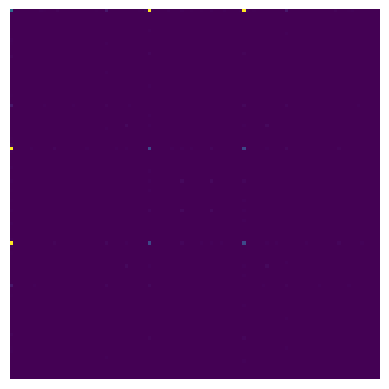

In [79]:
# neur_acts.shape
pre_mlp_r = einops.rearrange(pre_mlp, "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

for i in range(512):
    plt.clf()
    F_sparse, x_hat = fourier_approx_2d(pre_mlp_r[:,:,i], num_freqs=128)
    plt.imshow(np.abs(F_sparse));
    plt.axis('off')
    plt.savefig('/home/stephen/ARENA_3.0/viz/nov_24_4_pre_mlp/'+str(i).zfill(3)+'.png')

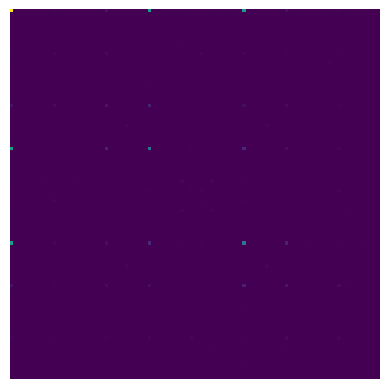

In [82]:
# neur_acts.shape
hidden_r = einops.rearrange(hidden, "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

for i in range(512):
    plt.clf()
    F_sparse, x_hat = fourier_approx_2d(hidden_r[:,:,i], num_freqs=128)
    plt.imshow(np.abs(F_sparse));
    plt.axis('off')
    plt.savefig('/home/stephen/ARENA_3.0/viz/nov_24_5_hidden/'+str(i).zfill(3)+'.png')

In [92]:
for k in cache:
    print(k, cache[k].shape)

hook_embed torch.Size([12769, 3, 128])
hook_pos_embed torch.Size([12769, 3, 128])
blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_q torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


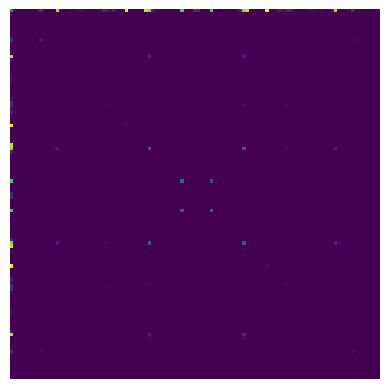

In [93]:
# neur_acts.shape
mr = einops.rearrange(cache['blocks.0.hook_attn_out'][:, -1, :], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

for i in range(128):
    plt.clf()
    F_sparse, x_hat = fourier_approx_2d(mr[:,:,i], num_freqs=128)
    plt.imshow(np.abs(F_sparse));
    plt.axis('off')
    plt.savefig('/home/stephen/ARENA_3.0/viz/nov_24_6_attn_out/'+str(i).zfill(3)+'.png')

In [80]:
hidden.shape

torch.Size([12769, 512])

In [59]:
pre_mlp.shape

torch.Size([12769, 512])

In [60]:
pre_mlp_r.shape

(113, 113, 512)

---

In [153]:
import numpy as np
import matplotlib.pyplot as plt

def decompose_frequency_components(M, ks, subtract_mean=True):
    """
    Decompose M into components associated with different patterns and frequencies.

    Parameters
    ----------
    M : 2D np.ndarray, shape (N, N)
        Input matrix (e.g. 113x113).
    ks : iterable of ints
        Allowed frequency indices (e.g. [14, 35, 41, 42, 51]).
    subtract_mean : bool
        If True, subtract the global mean before FFT.

    Returns
    -------
    result : dict
        {
          'N': N,
          'total_energy': float,
          'components': {
             'sum': {
                k: {'component': 2D array, 'energy': float, 'energy_frac': float},
                ...
             },
             'product': { ... },
             'diag': { ... }
          },
          'fft': 2D complex array (the full FFT of the centered matrix)
        }
    """
    M = np.asarray(M)
    assert M.ndim == 2 and M.shape[0] == M.shape[1], "M must be square"
    N = M.shape[0]

    if subtract_mean:
        M_centered = M - np.mean(M)
    else:
        M_centered = M

    F = np.fft.fft2(M_centered)
    total_energy = np.sum(np.abs(F)**2)

    components = {
        'sum': {},      # A cos(kx) + B cos(ky) family
        'product': {},  # A cos(kx) cos(ky) family
        'diag': {}      # A cos(k(x+y)) family (sum-of-angles)
    }

    def idx(pos_k):
        # Map possibly negative k to [0, N-1] index
        return pos_k % N

    for k in ks:
        # ---------- Pattern 1: sum model ----------
        # Frequencies: (k,0), (-k,0), (0,k), (0,-k)
        mask_sum = np.zeros_like(F, dtype=bool)
        mask_sum[idx(k), idx(0)] = True
        mask_sum[idx(-k), idx(0)] = True
        mask_sum[idx(0), idx(k)] = True
        mask_sum[idx(0), idx(-k)] = True

        F_sum = np.zeros_like(F)
        F_sum[mask_sum] = F[mask_sum]
        M_sum = np.fft.ifft2(F_sum).real
        E_sum = np.sum(np.abs(F[mask_sum])**2)
        components['sum'][k] = {
            'component': M_sum,
            'energy': E_sum,
            'energy_frac': E_sum / total_energy if total_energy > 0 else 0.0
        }

        # ---------- Pattern 2: product model ----------
        # Frequencies: (k,k), (-k,-k), (k,-k), (-k,k)
        mask_prod = np.zeros_like(F, dtype=bool)
        mask_prod[idx(k), idx(k)] = True
        mask_prod[idx(-k), idx(-k)] = True
        mask_prod[idx(k), idx(-k)] = True
        mask_prod[idx(-k), idx(k)] = True

        F_prod = np.zeros_like(F)
        F_prod[mask_prod] = F[mask_prod]
        M_prod = np.fft.ifft2(F_prod).real
        E_prod = np.sum(np.abs(F[mask_prod])**2)
        components['product'][k] = {
            'component': M_prod,
            'energy': E_prod,
            'energy_frac': E_prod / total_energy if total_energy > 0 else 0.0
        }

        # ---------- Pattern 3: diag (sum-of-angles) ----------
        # Frequencies: (k,k), (-k,-k) only
        mask_diag = np.zeros_like(F, dtype=bool)
        mask_diag[idx(k), idx(k)] = True
        mask_diag[idx(-k), idx(-k)] = True

        F_diag = np.zeros_like(F)
        F_diag[mask_diag] = F[mask_diag]
        M_diag = np.fft.ifft2(F_diag).real
        E_diag = np.sum(np.abs(F[mask_diag])**2)
        components['diag'][k] = {
            'component': M_diag,
            'energy': E_diag,
            'energy_frac': E_diag / total_energy if total_energy > 0 else 0.0
        }

    result = {
        'N': N,
        'total_energy': total_energy,
        'components': components,
        'fft': F
    }
    return result

def plot_components_grid(result, pattern_type='sum', ks=None, cmap='RdBu_r'):
    """
    Visualize components for a given pattern type (sum, product, or diag)
    across multiple k values.

    Parameters
    ----------
    result : dict
        Output of decompose_frequency_components.
    pattern_type : str
        One of 'sum', 'product', 'diag'.
    ks : list or None
        Which ks to show. If None, use all ks present in result.
    cmap : str
        Matplotlib colormap.
    """
    components = result['components'][pattern_type]
    if ks is None:
        ks = sorted(components.keys())

    n_k = len(ks)
    ncols = n_k
    nrows = 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    if n_k == 1:
        axes = [axes]  # make iterable

    vmax = max(np.max(np.abs(components[k]['component'])) for k in ks)
    # Symmetric color scale around 0 to make positive/negative patterns clear
    vmin = -vmax

    for ax, k in zip(axes, ks):
        comp = components[k]['component']
        energy_frac = components[k]['energy_frac']

        im = ax.imshow(comp, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(f"{pattern_type}, k={k}\nenergy={energy_frac:.2%}")
        ax.set_xticks([])
        ax.set_yticks([])

    fig.colorbar(im, ax=axes, shrink=0.8)
    fig.suptitle(f"Components for pattern_type='{pattern_type}'", fontsize=14)
    # plt.tight_layout()
    plt.show()

In [199]:
ks = [14, 35, 41, 42, 51]
neuron_idx=4

result = decompose_frequency_components(mr[:,:,-2, neuron_idx], ks)

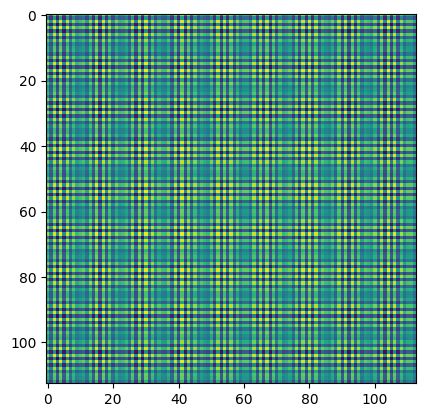

In [200]:
plt.imshow(mr[:,:,-2, neuron_idx])

In [201]:
result.keys()

dict_keys(['N', 'total_energy', 'components', 'fft'])

In [202]:
result['N']

113

In [203]:
result['total_energy']

510878101.92820793

In [204]:
result['components'].keys()

dict_keys(['sum', 'product', 'diag'])

In [205]:
result['components']['sum'].keys()

dict_keys([14, 35, 41, 42, 51])

In [206]:
result['components']['sum'][14].keys()

dict_keys(['component', 'energy', 'energy_frac'])

In [207]:
result['components']['sum'][14]['component'].shape

(113, 113)

In [208]:
# plt.imshow(result['components']['sum'][14]['component'])

In [209]:
# plt.imshow(result['components']['product'][14]['component'])

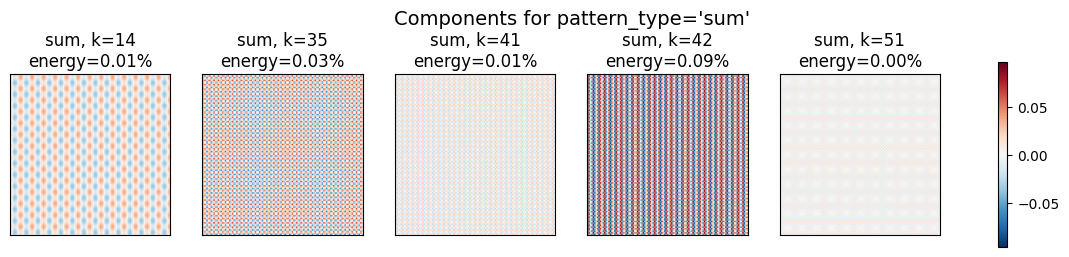

In [210]:
plot_components_grid(result, pattern_type='sum', ks=ks)

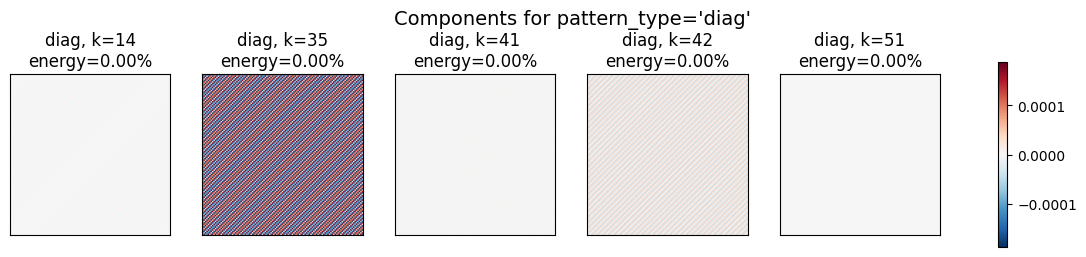

In [211]:
plot_components_grid(result, pattern_type='diag', ks=ks)

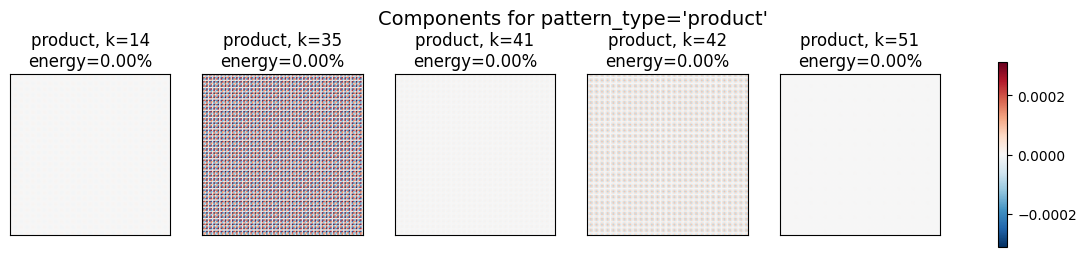

In [212]:
plot_components_grid(result, pattern_type='product', ks=ks)

---

In [86]:
terms_1d

[{'k': 42, 'amplitude': 1.4857792277859159, 'phase': 2.683707368810435}]

In [76]:
W_neur.shape

torch.Size([4, 113, 512])

In [20]:
W_neur[1][:,neuron_idx].shape

torch.Size([113])

In [34]:
for i in range(500, 520):
    print(all_data[i, :], logits[i].argmax())

tensor([  4,  48, 113], device='cuda:0') tensor(52, device='cuda:0')
tensor([  4,  49, 113], device='cuda:0') tensor(53, device='cuda:0')
tensor([  4,  50, 113], device='cuda:0') tensor(54, device='cuda:0')
tensor([  4,  51, 113], device='cuda:0') tensor(55, device='cuda:0')
tensor([  4,  52, 113], device='cuda:0') tensor(34, device='cuda:0')
tensor([  4,  53, 113], device='cuda:0') tensor(57, device='cuda:0')
tensor([  4,  54, 113], device='cuda:0') tensor(58, device='cuda:0')
tensor([  4,  55, 113], device='cuda:0') tensor(18, device='cuda:0')
tensor([  4,  56, 113], device='cuda:0') tensor(60, device='cuda:0')
tensor([  4,  57, 113], device='cuda:0') tensor(61, device='cuda:0')
tensor([  4,  58, 113], device='cuda:0') tensor(79, device='cuda:0')
tensor([  4,  59, 113], device='cuda:0') tensor(63, device='cuda:0')
tensor([  4,  60, 113], device='cuda:0') tensor(64, device='cuda:0')
tensor([  4,  61, 113], device='cuda:0') tensor(106, device='cuda:0')
tensor([  4,  62, 113], device='c

In [12]:
W_O.shape

torch.Size([4, 32, 128])

In [10]:
W_V.shape

torch.Size([4, 128, 32])

In [13]:
W_OV.shape

torch.Size([4, 128, 128])

In [11]:
W_E.shape

torch.Size([113, 128])

In [15]:
(W_E @ W_V).shape

torch.Size([4, 113, 32])

In [28]:
W_neur.shape

torch.Size([4, 113, 512])

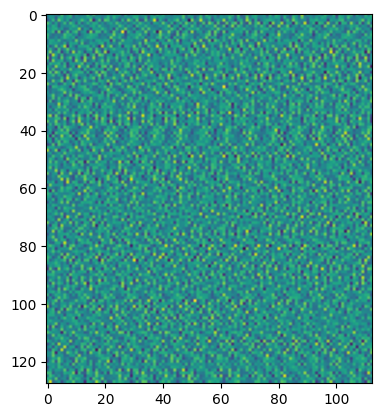

In [26]:
plt.imshow((W_E @ W_OV)[3].detach().cpu().numpy().T)

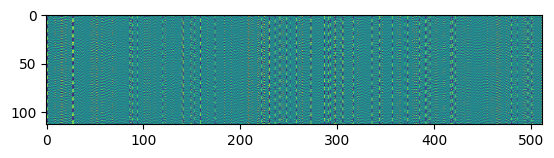